Train 16-split regression from scratch.

In [1]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

def embed_and_translate(data, nrows, ncols):
    ndata = np.zeros((len(data), nrows, ncols, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    for i in range(len(data)):
        x = np.random.randint(ncols-width)
        y = np.random.randint(nrows-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations
            
n_splits = 16
io_shape = (56,56,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16 * 4 # since we have 4x4-splits we need 4 times the latent space for a fair comparison.

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_augmented, y_train = embed_and_translate(x_train, 56, 56)
x_train_split = np.array([utils.split(x, size, size) for x in x_train_augmented], dtype='float32')

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_augmented, y_test = embed_and_translate(x_test, 56, 56)
x_test_split = np.array([utils.split(x, size, size) for x in x_test_augmented], dtype='float32')

In [5]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, io_shape):
        super(MultiSplit, self).__init__()
        n_filters = [32, 64]
        size = int( io_shape[0] // (n_splits**(1/2)) )  # W = H
        self.encoder = self._create_encoder(latent_dim//n_splits, (size, size,1), n_filters)
        self.input_reshaper = utils.Reshaper((n_splits, size, size, 1), (size, size,1))
        self.latent_reshaper = utils.Reshaper([latent_dim//n_splits], [latent_dim])
        self.regressor = self._create_regressor(latent_dim)
#         self.decoder = self._create_decoder(latent_dim, io_shape, n_filters)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
#         y_pred = self.decode(z ,training=training)
        y_pred = self.regress(z ,training=training)
        return y_pred
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def regress(self, z, training=True):
        return self.regressor( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Dense(units=latent_dim, activation='sigmoid')
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * 8),
            Reshape((io_shape[0]//4, io_shape[1]//4, 8)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(64, activation='elu'),
            Dense(64, activation='elu'),
            Dense(2, activation='linear')
        ])

In [6]:
model = MultiSplit(n_splits, latent_dim, io_shape)
model.compile(loss='mean_absolute_percentage_error', optimizer='adam') # COMPILE AFTER WEIGHTS LOADED

Epoch 1/25
1875/1875 [==============================] - 6s 3ms/step - loss: 9.5806 - val_loss: 3.7671
Epoch 2/25
1875/1875 [==============================] - 6s 3ms/step - loss: 3.3262 - val_loss: 2.7573
Epoch 3/25
1875/1875 [==============================] - 6s 3ms/step - loss: 2.4772 - val_loss: 1.9837
Epoch 4/25
1875/1875 [==============================] - 6s 3ms/step - loss: 2.0642 - val_loss: 1.9815
Epoch 5/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.8635 - val_loss: 1.6014
Epoch 6/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.6982 - val_loss: 1.5202
Epoch 7/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.5879 - val_loss: 1.6783
Epoch 8/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.5037 - val_loss: 1.3753
Epoch 9/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4522 - val_loss: 1.4581
Epoch 10/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.404

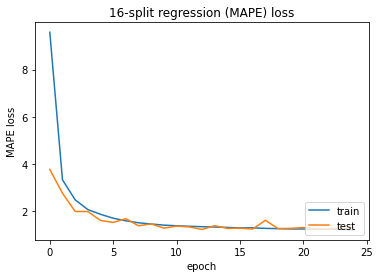

<Figure size 432x288 with 0 Axes>

In [7]:
history = model.fit(x_train_split, y_train, validation_data=(x_test_split, y_test), epochs=25, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('16-split regression (MAPE) loss')
plt.ylabel('MAPE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

# plt.savefig('../img/32/CE4x16_epoch25.png')

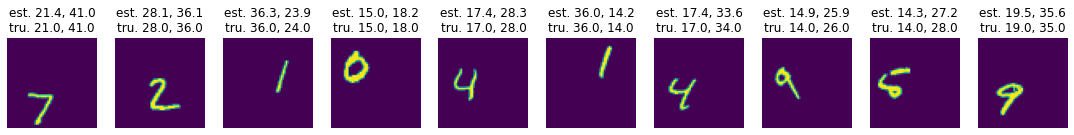

In [9]:
import matplotlib.pyplot as plt
import tensorflow as tf

y = model.predict(x_test_split)
n = 10
plt.figure(figsize=(19, 6))
for i in range(n):
    
    plt.subplot(1,n,i+1)
    plt.axis('off')
    plt.title("est. {:3.1f}, {:3.1f}\ntru. {:3.1f}, {:3.1f}".format(y[i][1], y[i][0], y_test[i][1], y_test[i][0]))
    plt.imshow(x_test_augmented[i].reshape(56,56))